Saving cleaned_weather.csv to cleaned_weather.csv
ADF Test p-value: 5.706553805744427e-14


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE: 0.00
MAE: 0.00
MAPE: 31168041568.05%
R-squared: 1.00


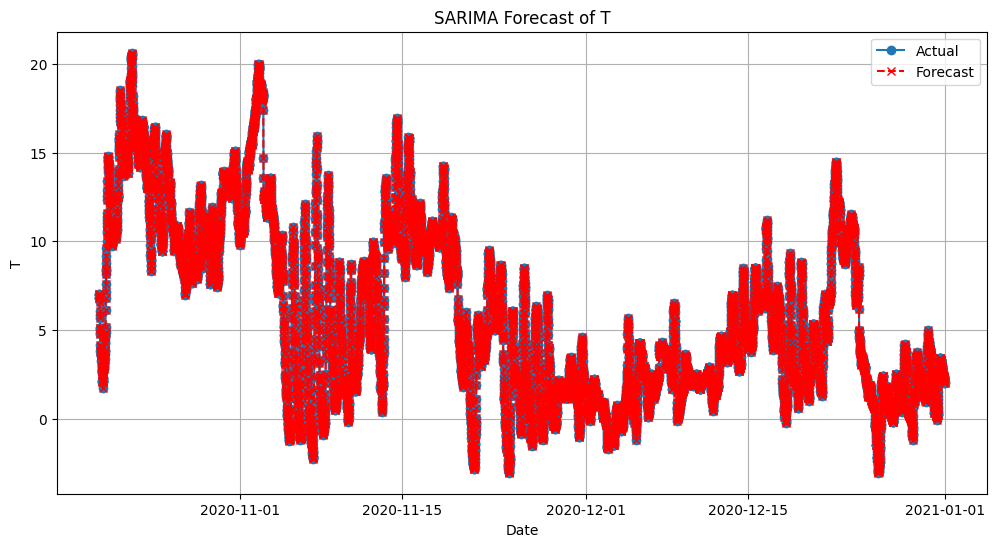

In [1]:
# STEP 1: Install necessary packages
!pip install statsmodels --quiet

# STEP 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# STEP 3: Upload and load dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("cleaned_weather.csv")

# STEP 4: Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)

# STEP 5: Select target and create features
target = 'T'  # You can change to 'rh', 'rain', etc.
df_filtered = df[[target]].copy()

# Create lag features
df_filtered[f'{target}_lag1'] = df_filtered[target].shift(1)
df_filtered[f'{target}_lag2'] = df_filtered[target].shift(2)
df_filtered[f'{target}_lag3'] = df_filtered[target].shift(3)

# Rolling statistics
df_filtered[f'{target}_rollmean'] = df_filtered[target].rolling(window=3).mean()
df_filtered[f'{target}_rollstd'] = df_filtered[target].rolling(window=3).std()

# Drop missing values from lag/rolling
df_filtered.dropna(inplace=True)

# STEP 6: Train-test split
train_size = int(len(df_filtered) * 0.8)
train = df_filtered.iloc[:train_size]
test = df_filtered.iloc[train_size:]

# STEP 7: Check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Test p-value: {result[1]}")
    return result[1]

p_value = check_stationarity(train[target])

# Apply differencing if not stationary
d = 1 if p_value > 0.05 else 0
if d == 1:
    train[target] = train[target].diff().dropna()
    test[target] = test[target].diff().dropna()

# STEP 8: Train SARIMA model
exog_cols = [f'{target}_lag1', f'{target}_lag2', f'{target}_lag3',
             f'{target}_rollmean', f'{target}_rollstd']

sarima_model = SARIMAX(train[target],
                       exog=train[exog_cols],
                       order=(1, d, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

model_result = sarima_model.fit(disp=False)

# STEP 9: Forecast
forecast_steps = len(test)
forecast = model_result.predict(start=len(train),
                                end=len(train) + forecast_steps - 1,
                                exog=test[exog_cols])

# STEP 10: Evaluation
rmse = np.sqrt(mean_squared_error(test[target], forecast))
mae = mean_absolute_error(test[target], forecast)
mape = mean_absolute_percentage_error(test[target], forecast) * 100
r2 = r2_score(test[target], forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.2f}")

# STEP 11: Plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, test[target], label='Actual', marker='o')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', marker='x', color='red')
plt.title(f"SARIMA Forecast of {target}")
plt.xlabel("Date")
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()
